In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from sklearn.preprocessing import MinMaxScaler


In [47]:
data = pd.read_csv('Covid-19_VietNam.csv', usecols=[1,5,6])
data['dateRep'] = pd.to_datetime(data['dateRep'])
data.head()

,dateRep,cases,total
0,2019-12-31,0,0
1,2020-01-01,0,0
2,2020-01-02,0,0
3,2020-01-03,0,0
4,2020-01-04,0,0


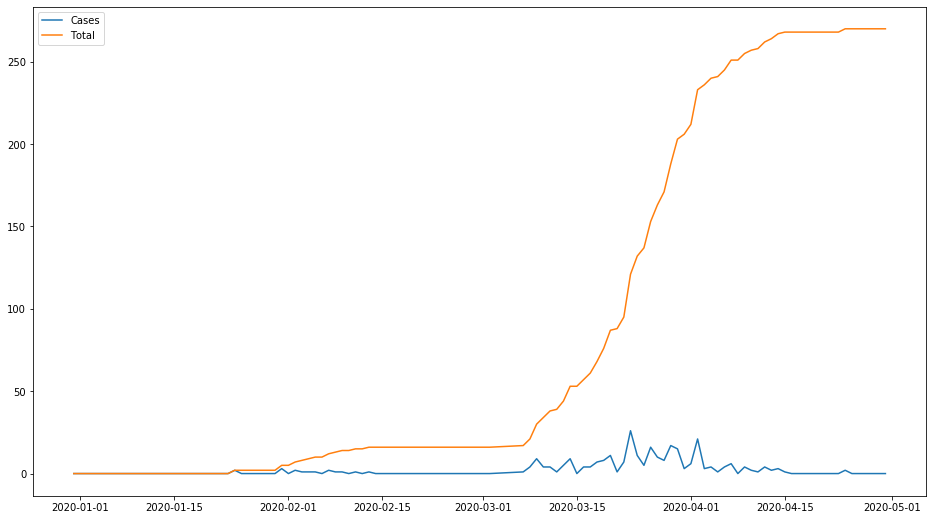

In [48]:
plt.figure(figsize=(16,9))
x = data['dateRep']
y = data['cases']
z = data['total']
plt.plot(x,y)
plt.plot(x,z)
plt.legend(['Cases', 'Total'])
plt.show()

In [49]:
def create_dataset(dataset, look_back=9):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back),0]
		dataX.append(a)
		dataY.append(dataset[i + look_back,0])
	return np.array(dataX), np.array(dataY)


In [50]:
from sklearn.preprocessing import MinMaxScaler
dataset = data['cases'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(118, 1)

In [51]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [52]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX)

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.07692308]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.11538462]
 [0.        ]
 [0.07692308]
 [0.03846154]
 [0.03846154]
 [0.03846154]
 [0.        ]
 [0.07692308]
 [0.03846154]
 [0.03846154]
 [0.        ]
 [0.03846154]
 [0.        ]
 [0.03846154]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03846154]
 [0.15384616]
 [0.34615386]
 [0.15384616]
 [0.15384616]
 [0.03846154]
 [0.1923077 ]
 [0.34615386]
 [0.  

In [53]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [54]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=2, verbose=2)

Epoch 1/15
40/40 - 0s - loss: 0.0222
Epoch 2/15
40/40 - 0s - loss: 0.0204
Epoch 3/15
40/40 - 0s - loss: 0.0191
Epoch 4/15
40/40 - 0s - loss: 0.0193
Epoch 5/15
40/40 - 0s - loss: 0.0187
Epoch 6/15
40/40 - 0s - loss: 0.0184
Epoch 7/15
40/40 - 0s - loss: 0.0174
Epoch 8/15
40/40 - 0s - loss: 0.0180
Epoch 9/15
40/40 - 0s - loss: 0.0173
Epoch 10/15
40/40 - 0s - loss: 0.0168
Epoch 11/15
40/40 - 0s - loss: 0.0163
Epoch 12/15
40/40 - 0s - loss: 0.0158
Epoch 13/15
40/40 - 0s - loss: 0.0155
Epoch 14/15
40/40 - 0s - loss: 0.0150
Epoch 15/15
40/40 - 0s - loss: 0.0156


In [55]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = trainPredict.reshape(-1,1)
testPredict = testPredict.reshape(-1,1)
#trainPredict = scaler.inverse_transform(trainPredict)
#testPredict = scaler.inverse_transform(testPredict)
#dataset = scaler.inverse_transform(dataset)

In [56]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
dataset = scaler.inverse_transform(dataset)

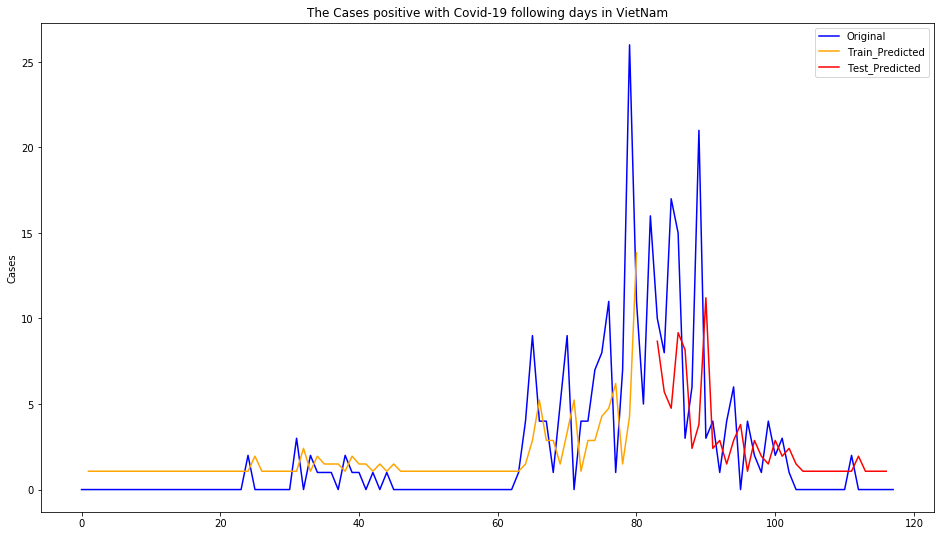

In [57]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(16,9))
plt.plot(dataset, color = 'blue')
plt.plot(trainPredictPlot, color = 'orange')
plt.plot(testPredictPlot, color = 'red')
plt.legend(['Original','Train_Predicted','Test_Predicted'])
plt.title('The Cases positive with Covid-19 following days in VietNam')
plt.ylabel('Cases')
plt.show()

In [58]:
testY =scaler.inverse_transform(testY.reshape(-1,1))

In [59]:
testY

array([[10.      ],
       [ 8.      ],
       [17.      ],
       [14.999999],
       [ 3.      ],
       [ 6.      ],
       [21.      ],
       [ 3.      ],
       [ 4.      ],
       [ 1.      ],
       [ 4.      ],
       [ 6.      ],
       [ 0.      ],
       [ 4.      ],
       [ 2.      ],
       [ 1.      ],
       [ 4.      ],
       [ 2.      ],
       [ 3.      ],
       [ 1.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 2.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ]], dtype=float32)

In [60]:
testPredict

array([[ 8.668989 ],
       [ 5.7137094],
       [ 4.7538114],
       [ 9.171151 ],
       [ 8.169375 ],
       [ 2.4093013],
       [ 3.8065643],
       [11.212053 ],
       [ 2.4093013],
       [ 2.8719165],
       [ 1.4941494],
       [ 2.8719165],
       [ 3.8065643],
       [ 1.0715473],
       [ 2.8719165],
       [ 1.9499438],
       [ 1.4941494],
       [ 2.8719165],
       [ 1.9499438],
       [ 2.4093013],
       [ 1.4941494],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.9499438],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473],
       [ 1.0715473]], dtype=float32)

In [61]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
MAE = mean_absolute_error(testY, testPredict)
MSE = mean_squared_error(testY, testPredict)
RMSE = np.sqrt(MSE)
print(MAE)
print(MSE)
print(RMSE)

2.8090594
19.708626
4.43944


In [62]:
from sklearn.preprocessing import MinMaxScaler
dataset = data['cases'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(118, 1)

In [63]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [64]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [65]:
ANN_model = Sequential()
ANN_model.add(Dense(512, input_shape=(1, look_back), activation='relu'))
ANN_model.add(Dense(1))
ANN_model.compile(loss='mean_squared_error', optimizer='adam')
ANN_model.fit(trainX, trainY, epochs=20, batch_size=2, verbose=2)

Epoch 1/20
40/40 - 0s - loss: 0.0186
Epoch 2/20
40/40 - 0s - loss: 0.0152
Epoch 3/20
40/40 - 0s - loss: 0.0144
Epoch 4/20
40/40 - 0s - loss: 0.0142
Epoch 5/20
40/40 - 0s - loss: 0.0148
Epoch 6/20
40/40 - 0s - loss: 0.0139
Epoch 7/20
40/40 - 0s - loss: 0.0141
Epoch 8/20
40/40 - 0s - loss: 0.0144
Epoch 9/20
40/40 - 0s - loss: 0.0148
Epoch 10/20
40/40 - 0s - loss: 0.0141
Epoch 11/20
40/40 - 0s - loss: 0.0139
Epoch 12/20
40/40 - 0s - loss: 0.0141
Epoch 13/20
40/40 - 0s - loss: 0.0134
Epoch 14/20
40/40 - 0s - loss: 0.0138
Epoch 15/20
40/40 - 0s - loss: 0.0151
Epoch 16/20
40/40 - 0s - loss: 0.0141
Epoch 17/20
40/40 - 0s - loss: 0.0142
Epoch 18/20
40/40 - 0s - loss: 0.0136
Epoch 19/20
40/40 - 0s - loss: 0.0135
Epoch 20/20
40/40 - 0s - loss: 0.0140


In [66]:
trainPredict = ANN_model.predict(trainX)
testPredict = ANN_model.predict(testX)
trainPredict = trainPredict.reshape(-1,1)
testPredict = testPredict.reshape(-1,1)

In [67]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
dataset = scaler.inverse_transform(dataset)

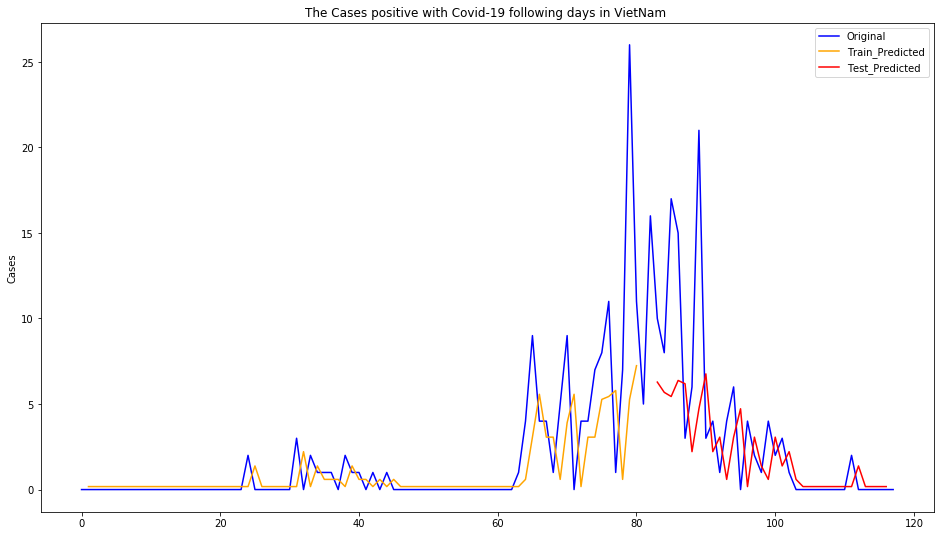

In [68]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(16,9))
plt.plot(dataset, color = 'blue')
plt.plot(trainPredictPlot, color = 'orange')
plt.plot(testPredictPlot, color = 'red')
plt.legend(['Original','Train_Predicted','Test_Predicted'])
plt.title('The Cases positive with Covid-19 following days in VietNam ')
plt.ylabel('Cases')
plt.show()

In [69]:
testY =scaler.inverse_transform(testY.reshape(-1,1))

In [70]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
MAE = mean_absolute_error(testY, testPredict)
MSE = mean_squared_error(testY, testPredict)
RMSE = np.sqrt(MSE)
print(MAE)
print(MSE)
print(RMSE)

2.5422208
18.21592
4.268011
